In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.qnn import TorchLayer
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA


from avalanche.benchmarks.classic import SplitMNIST
from avalanche.benchmarks import nc_benchmark
from avalanche.training import Naive
from avalanche.training.plugins import EvaluationPlugin,SupervisedPlugin, ReplayPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger
import pickle
import os
import numpy as np

2025-06-23 20:18:00.244921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 20:18:00.277419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 20:18:00.286630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 20:18:03.053632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

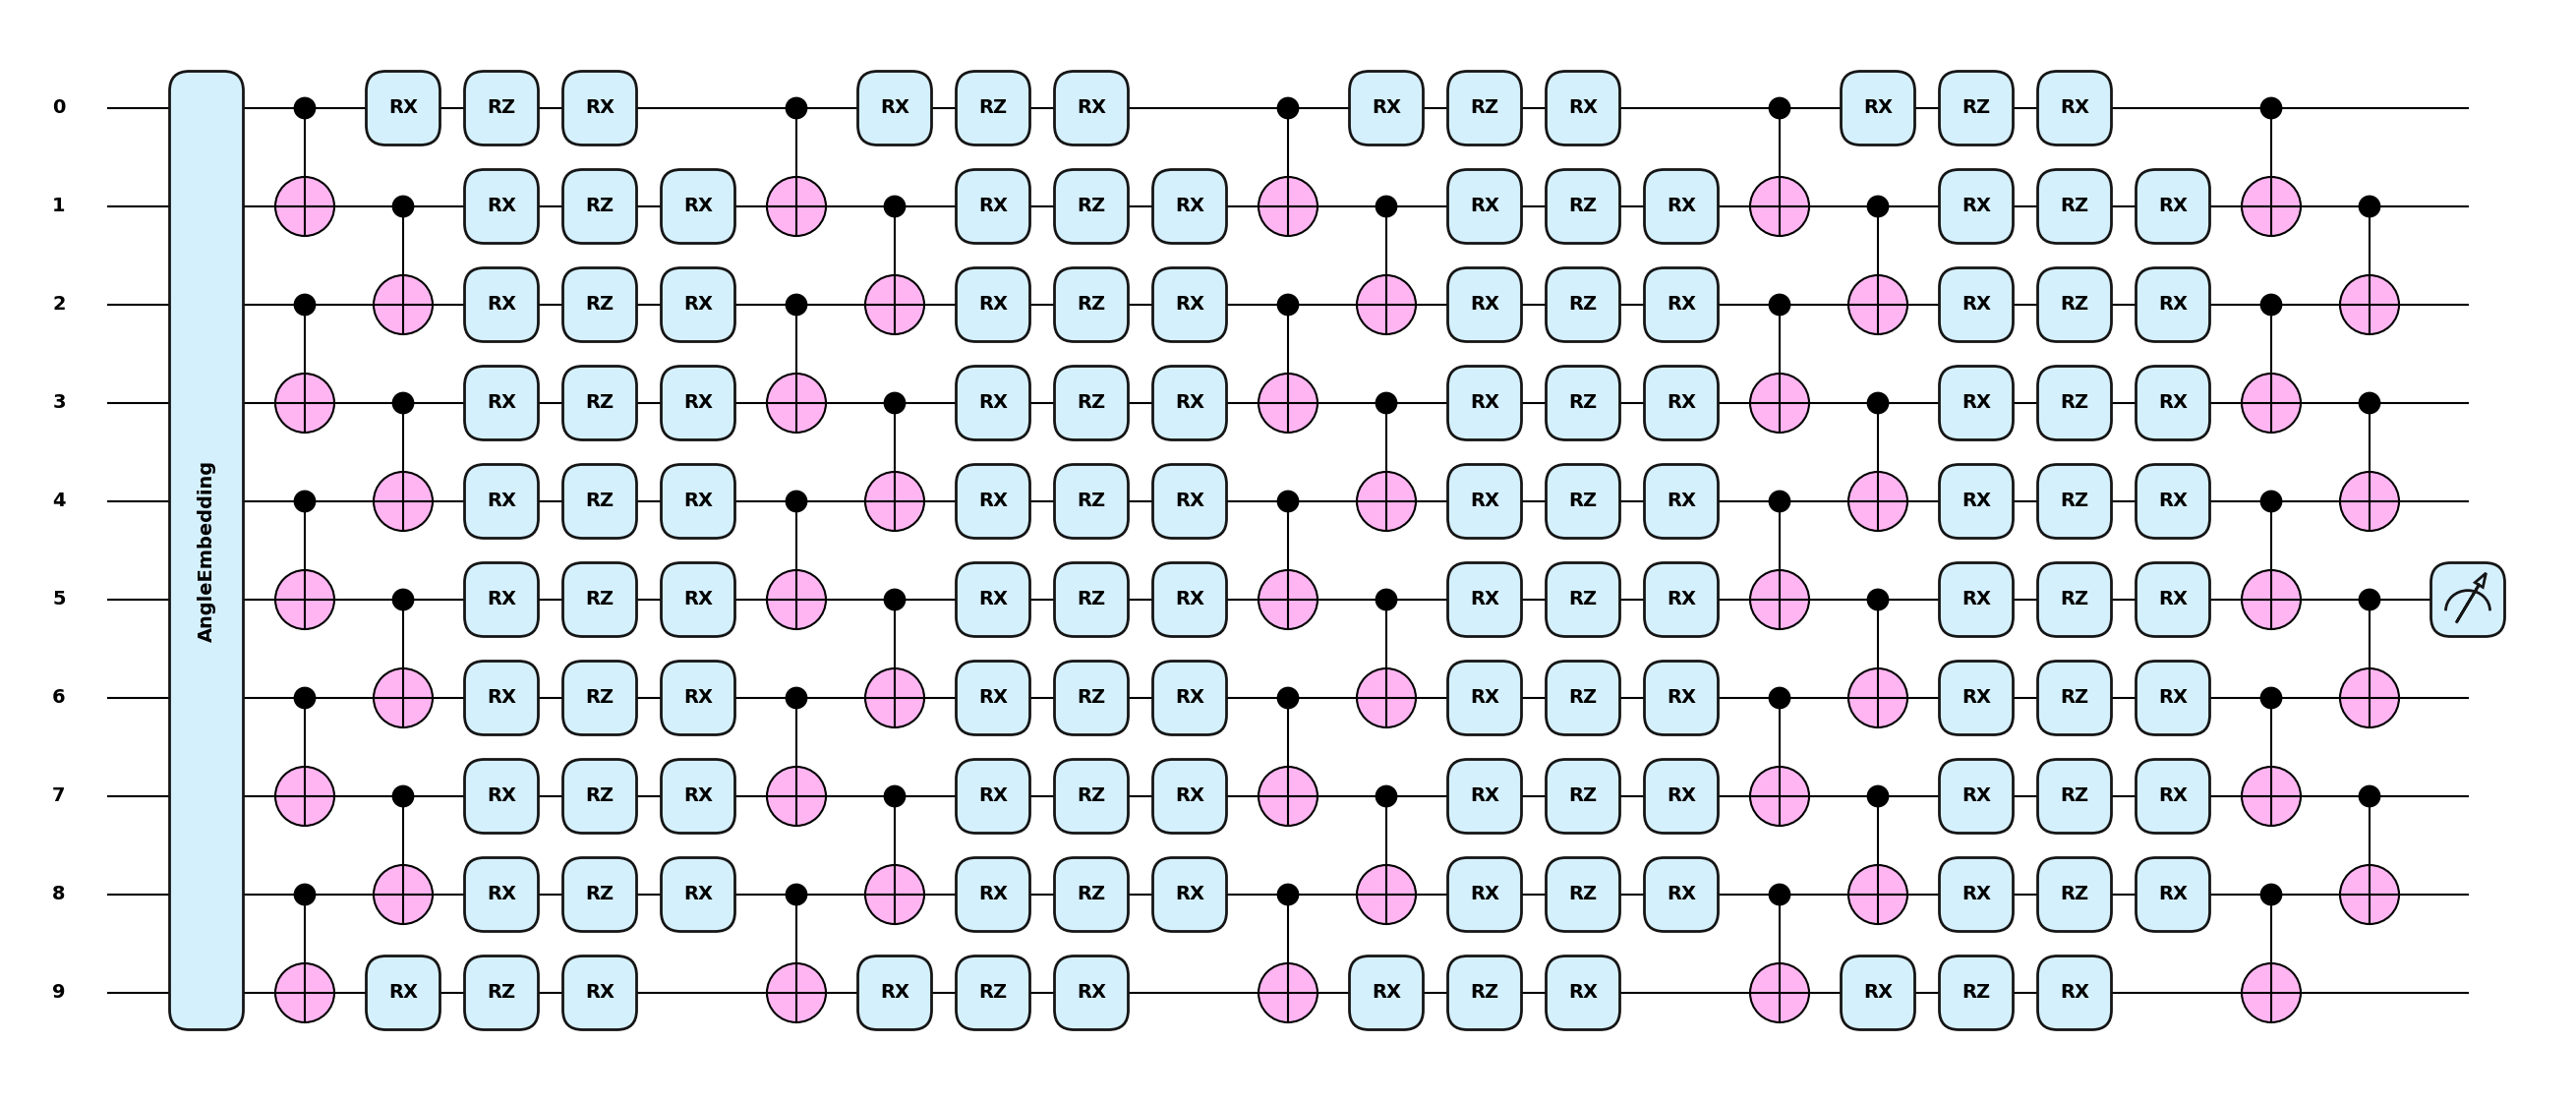

In [4]:
n_qubits = 10
n_layers = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

def feature_encoding(inputs):
    qml.AngleEmbedding(inputs, wires=list(range(n_qubits)), rotation='X')
        # 不是环形连接，只连接到下一个比特
    for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
    for i in range(1, n_qubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
            
def varitional_block(params):
    for i in range(n_qubits):
        qml.RX(params[0,i], wires=i)
        qml.RZ(params[1,i], wires=i)
        qml.RX(params[2,i], wires=i)
    for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
    for i in range(1, n_qubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    feature_encoding(inputs)
    for layer in range(n_layers):
        varitional_block(weights[layer])
    return qml.expval(qml.PauliZ(n_qubits // 2))  # 返回中间比特的期望值

qml.drawer.use_style("pennylane")
# 输入：10个量子比特
inputs = torch.randn(n_qubits)
# 权重：4 层，每层 8 比特，每比特三个参数（RX, RZ, RX）
weights = torch.randn(n_layers, 3, n_qubits)
# 绘制量子电路
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()
    

In [5]:
# -----------------------------
# 2. TorchLayer + PyTorch Model
# -----------------------------
weight_shapes = {"weights": (n_layers, 3, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch")
qlayer = TorchLayer(qnode, weight_shapes)
with torch.no_grad():
    qlayer.weights.data = qlayer.weights.data * 0.1

class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 添加一个线性层将784维输入压缩到n_qubits维
        self.compression = nn.Linear(784, n_qubits)
        self.q_layer = qlayer
        self.output = nn.Linear(1, 10)  # 输出10个类别

    def forward(self, x):
        # 压缩输入维度 (batch_size, 784) -> (batch_size, n_qubits)
        x = self.compression(x)
        
        # 应用量子层
        x = self.q_layer(x)
        
        # 准备输出
        x = x.unsqueeze(1)  # 添加维度 (batch_size, 1)
        x = self.output(x)   # 转换为10个类别
        return F.log_softmax(x, dim=1)

In [ ]:
# # -----------------------------------------------------------------------------
# # 1) 用 SplitMNIST 的 train_stream 来增量拟合 PCA
# # -----------------------------------------------------------------------------
# # 先建一个只为了 PCA 拟合的 benchmark，不给它任何 transform
# benchmark_pca = SplitMNIST(
#     n_experiences=5,
#     return_task_id=False,
#     train_transform=None,   # 这里不做任何转码，dataset 直接产出 PIL.Image
#     eval_transform=None
# )

# # IncrementalPCA(784 → 256)
# ipca = IncrementalPCA(n_components=256)
# batch_size = 512
# processed = []
# # 2) 每个 experience，收集所有样本到一个数组，再按块拟合
# for experience in benchmark_pca.train_stream:
#     exp_id = experience.current_experience
#     # 收集本 experience 的所有展平图像
#     all_imgs = []
#     all_labels = []
#     for sample in experience.dataset:
#         # sample 可能是 (img, label, task_id)
#         img = sample[0]                    # PIL.Image
#         label = sample[1]                  # 对应的 label
#         arr = np.array(img, np.float32).reshape(-1)  # (784,)
#         all_imgs.append(arr)
#         all_labels.append(int(label))
#     all_imgs = np.stack(all_imgs, axis=0)  # (Ni, 784)

#     # 增量拟合 PCA
#     n_full = (all_imgs.shape[0] // batch_size) * batch_size
#     for i in range(0, n_full, batch_size):
#         ipca.partial_fit(all_imgs[i : i + batch_size])
#     # 可选：丢弃尾部不足 batch_size 的样本

#     # 同时保存降维后的结果
#     arr256_all = ipca.transform(all_imgs[:n_full])  # (n_full, 256)
#     for vec, lbl in zip(arr256_all, all_labels[:n_full]):
#         processed.append((vec.astype(np.float32), lbl, exp_id))

# print("✔ PCA 拟合并数据预处理完成，样本已收集到 `processed` 列表。")

# # 保存到文件
# os.makedirs("/home/yangz2/code/quantum_cl/data", exist_ok=True)
# with open(os.path.join("/home/yangz2/code/quantum_cl/data", "splitmnist_pca256.pkl"), 'wb') as f:
#     pickle.dump(processed, f)
# print("✔ 所有样本已处理并保存到 /home/yangz2/code/quantum_cl/data/splitmnist_pca256.pkl")



✔ PCA 拟合并数据预处理完成，样本已收集到 `processed` 列表。
✔ 所有样本已处理并保存到 /home/yangz2/code/quantum_cl/data/splitmnist_pca256.pkl


In [10]:
# -----------------------------
# 3. Data Transform (简化处理)
# -----------------------------
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # 展平为784
    transforms.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),  # 确保在[0,1]范围内
])

benchmark = SplitMNIST(n_experiences=5, return_task_id=False,
                       train_transform=transform, eval_transform=transform)

In [11]:
# -----------------------------
# 4. Avalanche Strategy Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=10, save_image=True, stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger]
)

replay_plugin = ReplayPlugin(
    mem_size=200,
    batch_size=32,
    batch_size_mem=32,
    task_balanced_dataloader=False
)

strategy = Naive(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_epochs=20,
    device=device,
    evaluator=eval_plugin,
    plugins=[replay_plugin]
)

class GradientClipPlugin(SupervisedPlugin):
    def before_backward(self, strategy, **kwargs):
        torch.nn.utils.clip_grad_norm_(strategy.model.parameters(), max_norm=1.0)

strategy.plugins.append(GradientClipPlugin())

In [12]:
# -----------------------------
# 5. Training & Evaluation
# -----------------------------
task_accuracies = []
save_dir = "/home/yangz2/code/quantum_cl/results/list"
os.makedirs(save_dir, exist_ok=True)

print("Starting training...")
for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)
    
    print(f"--- Evaluating after experience {experience.current_experience} ---")
    results = strategy.eval(benchmark.test_stream)
    task_accuracies.append(results)
    
    # Save intermediate results
    with open(os.path.join(save_dir, f"interim_results_er_s2_qbit10_qdepth4_exp_{experience.current_experience}.pkl"), "wb") as f:
        pickle.dump(task_accuracies, f)

# Save final results
with open(os.path.join(save_dir, "splitmnist_er_s2_qbit10_qdepth4_tepoch10.pkl"), "wb") as f:
    pickle.dump(task_accuracies, f)

Starting training...

--- Training on experience 0 ---
-- >> Start of training phase << --
0it [00:00, ?it/s]

  1%|          | 94/12223 [00:11<22:20,  9.05it/s]  

KeyboardInterrupt: 

In [ ]:
# # Load results
# with open(os.path.join(save_dir, "splitmnist_EWC_s2_qbit8_qdepth4_tepoch10.pkl"), "rb") as f:
#     results = pickle.load(f)

In [ ]:
# import matplotlib.pyplot as plt

# # results = pickle.load(…)  # 已经加载好的 list of dict

# # 1) 准备横轴（experience 序号）
# exp_idxs = list(range(1, len(results) + 1))

# # 2) 从 results 中提取三条曲线
# accuracies  = [r['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for r in results]
# losses      = [r['Loss_Stream/eval_phase/test_stream/Task000']      for r in results]
# forgettings = [r['StreamForgetting/eval_phase/test_stream']         for r in results]

# # 3) 画 Accuracy
# plt.figure()
# plt.plot(exp_idxs, accuracies)
# plt.xlabel('Experience')
# plt.ylabel('Accuracy')
# plt.title('Accuracy over Experiences')
# plt.xticks(exp_idxs)
# plt.savefig(os.path.join(save_dir, "splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_acc.png"))

# # 4) 画 Loss
# plt.figure()
# plt.plot(exp_idxs, losses)
# plt.xlabel('Experience')
# plt.ylabel('Loss')
# plt.title('Loss over Experiences')
# plt.xticks(exp_idxs)
# plt.savefig(os.path.join(save_dir, "splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_loss.png"))

# # 5) 画 Forgetting
# plt.figure()
# plt.plot(exp_idxs, forgettings)
# plt.xlabel('Experience')
# plt.ylabel('Forgetting')
# plt.title('Forgetting over Experiences')
# plt.xticks(exp_idxs)
# plt.savefig(os.path.join(save_dir, "splitmnist_EWC_s2_qbit8_qdepth4_tepoch10_forget.png"))


NameError: name 'results' is not defined